# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [2]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid(),                
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # YOUR CODE HERE
    # Split data into train and test
    df_train, y_train, df_test, y_test = split_dataset(df, ['filename'], 0.3, 42)
    # Remove 'label' column from df_train and df_test to get X_train and X_test
    X_train = df_train.drop(columns=["label"])
    X_test = df_test.drop(columns=["label"])
    # Scale the X_train and X_test
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
  # YOUR CODE HERE
	def __init__(self, X, y):
		# Ensure that both X and y are of the same datatype
		self.X = torch.tensor(X, dtype=torch.float32)
		self.y = torch.tensor(y, dtype=torch.float32)
		self.dataset = torch.utils.data.TensorDataset(self.X, self.y)

	def __getitem__(self, index):
		return self.dataset[index]
        
	def __len__(self):
		return len(self.dataset)


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
  # YOUR CODE HERE
	training_data = CustomDataset(X_train_scaled, y_train)
	test_data = CustomDataset(X_test_scaled, y_test)
	train_dataloader = DataLoader(training_data, batch_size=256)
	test_dataloader = DataLoader(test_data, batch_size=256)
	return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [5]:
# YOUR CODE HERE
model = MLP(no_features=77, no_hidden=128, no_labels=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use binary cross entropy loss since there are only two classes
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
# YOUR CODE HERE

def train_epoch(train_dataloader, model, loss_fn, optimizer):
	no_batches = len(train_dataloader)
	no_input = len(train_dataloader.dataset)
	train_loss, accurate = 0, 0
	for i, (x, y) in enumerate(train_dataloader): #for each mini-batch of 256
		# Prediction
		y_pred = model(x) # shape: [256, 1]
		y_pred = y_pred.squeeze(dim=1) # to get shape [256]
		# Compute loss
		loss = loss_fn(y_pred.float(), y.float())
		train_loss += loss.item()
		# Compute accuracy
		# transform y_pred to give class 0 or class 1
		pred_label = [1 if i > 0.5 else 0 for i in y_pred]
		# compare pred_label with the ground truth y, add 1 to the accuracy variable if the prediction is correct
		accurate += sum([1 if i == j else 0 for i, j in zip(pred_label, y)])

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
				
	train_loss /= no_batches # average train loss per batch
	accurate /= no_input # average train accuracy across train inputs
	return train_loss, accurate


def test_epoch(test_dataloader, model, loss_fn):
	no_batches = len(test_dataloader)
	no_input = len(test_dataloader.dataset)
	test_loss, accurate = 0, 0
	with torch.no_grad():
		for i, (x, y) in enumerate(test_dataloader):
			# Prediction
			y_pred = model(x) # shape: [256, 1]
			y_pred = y_pred.squeeze(dim=1) # to get shape [256]
			# Compute loss 
			loss = loss_fn(y_pred.float(), y.float())
			test_loss += loss.item()
			# Compute accuracy
			# transform y_pred to give class 0 or class 1
			pred_label = [1 if i > 0.5 else 0 for i in y_pred]
			# compare pred_label with the ground truth y, add 1 to the accuracy variable if the prediction is correct
			accurate += sum([1 if i == j else 0 for i, j in zip(pred_label, y)])
		
	test_loss /= no_batches # average test loss per batch
	accurate /= no_input # average test accuracy across test inputs
	return test_loss, accurate


In [7]:
from common_utils import EarlyStopper
early_stopper = EarlyStopper()
no_epochs = 100

train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
for epoch in range(no_epochs):
	train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer)
	test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	if early_stopper.early_stop(test_loss):
		print("Early stopping at epoch number: ", epoch+1)
		break
	if epoch % 9 == 0:
		print(f"Epoch {epoch+1} of {no_epochs}")
		print("train_acc: ", train_acc, "---- train_loss: ", train_loss)
		print("test_acc: ", test_acc, "---- test_loss: ", test_loss)


Epoch 1 of 100
train_acc:  0.5373859462021566 ---- train_loss:  0.6884525327971487
test_acc:  0.5641238253178552 ---- test_loss:  0.6834574739138285
Epoch 10 of 100
train_acc:  0.706600308093376 ---- train_loss:  0.5658557162140355
test_acc:  0.6586511885019348 ---- test_loss:  0.6238062342007955
Epoch 19 of 100
train_acc:  0.7734328711932693 ---- train_loss:  0.4652616020404931
test_acc:  0.7028745163073521 ---- test_loss:  0.5851726333300272
Early stopping at epoch number:  22


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


In [16]:
# YOUR CODE HERE
def loss_epoch(no_epochs, train_loss_list, test_loss_list):
		# YOUR CODE HERE
		plt.figure(figsize=(12, 5))
		plt.ylabel("binary cross entopy loss ")
		plt.xlabel("epoch number")
		plt.plot(range(no_epochs), train_loss_list, label="train loss")
		plt.plot(range(no_epochs), test_loss_list, label="test loss")
		minposs = test_loss_list.index(min(test_loss_list))
		plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
		plt.legend()
		plt.show()

In [17]:
def acc_epoch(no_epochs, train_acc_list, test_acc_list):
		# YOUR CODE HERE
		plt.figure(figsize=(12, 5))
		plt.ylabel("accuracy")
		plt.xlabel("epoch number")
		plt.plot(range(no_epochs), train_acc_list, label="train accuracy")
		plt.plot(range(no_epochs), test_acc_list, label="test accuracy")
		plt.legend()
		plt.show()

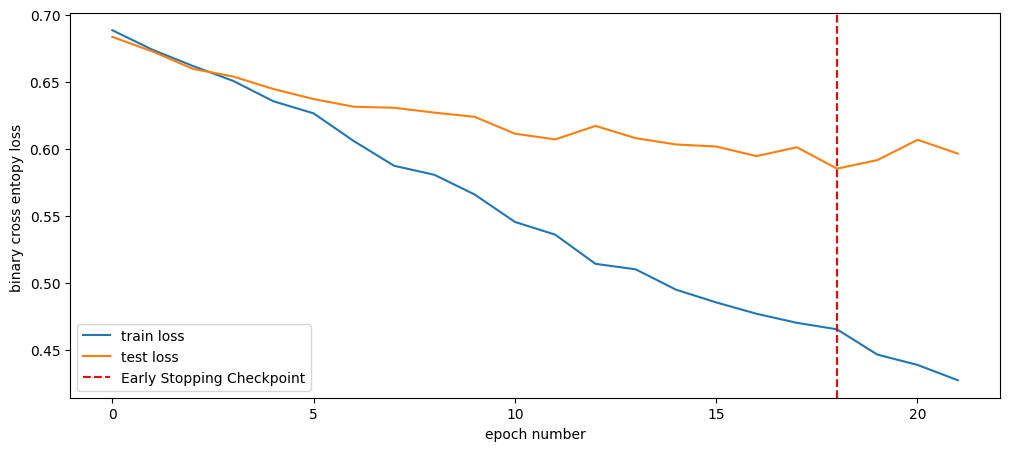

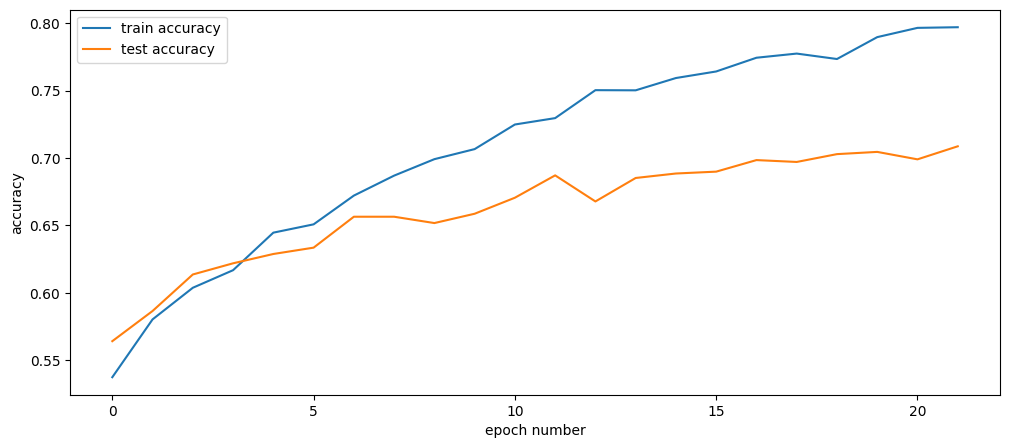

In [18]:

# From previous cell, we see that early stopping occured at the 22nd epoch
loss_epoch(len(train_loss_list), train_loss_list, test_loss_list)
acc_epoch(len(train_acc_list), train_acc_list, test_acc_list)

2. Comment on line plots.

In [11]:
# YOUR CODE HERE
answer = "Both the plots show that test loss is generally higher than train loss, while test accuracy is generally lower than train accuracy. This is because the model is trained on the train data, and the test data is unseen data. The model is not trained on the test data, so it is expected that the model will perform better on the train data than the test data.\
Additionally, after the test loss reduces drastically in the first 11 epochs, it starts plateauing. This is because the model has already learnt most features of the train data by then."